In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=cb6e476e06df70001eec68cc6b101a5a8e3ba9f581a41aeb515971cb322175a5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 29.8 MB/s 
     |████████████████████████████████| 895 kB 9.8 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 6.5 MB 31.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import os
import sys
import wget 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")

GPU is available!


Data               | Task                                      | Metric
-------------------|-------------------------------------------|----------------
CoLA               | Sentence is grammatical or not grammatical|Matthews
SST-2              | Review is positive negative or neutral    |Accuracy
RTE                | Sentence 1 -> Sentence 2?                 |Accuracy

## Data preprocessing 

In [6]:
sst2_link = 'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv'

In [7]:
sst2_data = pd.read_csv(sst2_link, delimiter="\t", names=["sentence", "label"], index_col=False)
print("Total of train sentences", sst2_data.shape[0])
print("Sample of tokenized sentence: ", sst2_data["sentence"][0])
sst2_data.head(5)

Total of train sentences 6920
Sample of tokenized sentence:  a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films


,sentence,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [8]:
train_sst2_data, test_sst2_data, train_sst2_labels, test_sst2_labels = train_test_split(sst2_data["sentence"], sst2_data["label"], train_size=0.8)

In [9]:
print(train_sst2_data.shape)
print(test_sst2_data.shape)
print(train_sst2_labels.shape)
print(test_sst2_labels.shape)

(5536,)
(1384,)
(5536,)
(1384,)


## Baseline - DistilBERT with default parameters

I tried both DistilBERT and BERT and got almost same results for baseline, so later I used DistilBERT as feature extractor to run my experiments faster

In [10]:
model_class, tokenizer_class, weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#model_class, tokenizer_class, weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model and tokenizer
tokenizer = tokenizer_class.from_pretrained(weights)
model = model_class.from_pretrained(weights)
model.eval()
model = model.to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
train_sst2_data[0]

'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'

In [12]:
tokenized_train = train_sst2_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = test_sst2_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [13]:
print(tokenized_train[0])

[101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102]


In [14]:
def add_padding(tokenized_data):
    max_len = max([len(line) for line in tokenized_data.values])
    padded_data = np.array([line + [0] * (max_len - len(line)) for line in tokenized_data.values])
    return padded_data

In [15]:
# padding
padded_train_data = add_padding(tokenized_train)
print(padded_train_data.shape)
# attention mask
mask_train = (padded_train_data > 0).astype(int)
print(mask_train.shape)

(5536, 67)
(5536, 67)


In [16]:
# padding
padded_test_data = add_padding(tokenized_test)
print(padded_test_data.shape)
# attention mask
mask_test = (padded_test_data > 0).astype(int)
print(mask_test.shape)

(1384, 66)
(1384, 66)


In [17]:
extracted_features_train = []
batch_size = 128
N = len(padded_train_data)
for i in range(0, N, batch_size):
    x_batch = torch.tensor(padded_train_data[i:i+batch_size]).to(device)
    mask_batch = torch.tensor(mask_train[i:i+batch_size]).to(device)

    # extract last hidden states
    with torch.no_grad():
        batch_features = model(x_batch, attention_mask=mask_batch)[0][:, 0, :].cpu().numpy()
        extracted_features_train.append(batch_features)

In [18]:
extracted_features_test = []
batch_size = 128
N = len(padded_test_data)
for i in range(0, N, batch_size):
    x_batch = torch.tensor(padded_test_data[i:i+batch_size]).to(device)
    mask_batch = torch.tensor(mask_test[i:i+batch_size]).to(device)

    # extract last hidden states
    with torch.no_grad():
        batch_features = model(x_batch, attention_mask=mask_batch)[0][:, 0, :].cpu().numpy()
        extracted_features_test.append(batch_features)

In [19]:
train_features = np.vstack(extracted_features_train)
test_features = np.vstack(extracted_features_test)

In [20]:
print(train_features.shape)

(5536, 768)


In [21]:
print(test_features.shape)

(1384, 768)


Default Logistic Regression

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

In [ ]:
clf_model = LogisticRegression()
clf_model.fit(train_features, train_sst2_labels)
pred_labels = clf_model.predict(train_features)
pred_labels_test = clf_model.predict(test_features)

In [ ]:
print(accuracy_score(train_sst2_labels, pred_labels))
print(accuracy_score(test_sst2_labels, pred_labels_test))

0.8757225433526011
0.8540462427745664


Normalized data + gridsearch

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_features)
scaled_test = scaler.transform(test_features)

In [ ]:
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer, refit=True)
grid_search.fit(scaled_train, train_sst2_labels)

print('best C parameter: ', grid_search.best_params_)

best C parameter:  {'C': 0.01}


In [ ]:
pred_labels_train = grid_search.predict(scaled_train)
pred_labels_test = grid_search.predict(scaled_test)
print(accuracy_score(train_sst2_labels, pred_labels))
print(accuracy_score(test_sst2_labels, pred_labels_test))

0.8757225433526011
0.8554913294797688


## Custom classifier

In [ ]:
train_features = torch.tensor(scaled_train)
train_labels = torch.tensor(train_sst2_labels.values)
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [ ]:
test_features = torch.tensor(scaled_test)
test_labels = torch.tensor(test_sst2_labels.values)
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        self.lin1 = nn.Linear(768, 1024)
        self.lin2 = nn.Linear(1024, 128)
        self.lin3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        output = self.lin3(x)
        #return output
        return F.log_softmax(output, dim=1)

In [ ]:
model = CustomClassifier()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

hist = []

# training cycle
for t in range(10):
    for x_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, labels_batch)
        loss.backward()
        optimizer.step()
    print(loss)
    hist.append(loss.detach()) 

tensor(0.3718, grad_fn=<NllLossBackward0>)
tensor(0.2159, grad_fn=<NllLossBackward0>)
tensor(0.1496, grad_fn=<NllLossBackward0>)
tensor(0.1121, grad_fn=<NllLossBackward0>)
tensor(0.0874, grad_fn=<NllLossBackward0>)
tensor(0.0690, grad_fn=<NllLossBackward0>)
tensor(0.0551, grad_fn=<NllLossBackward0>)
tensor(0.0432, grad_fn=<NllLossBackward0>)
tensor(0.0337, grad_fn=<NllLossBackward0>)
tensor(0.0262, grad_fn=<NllLossBackward0>)


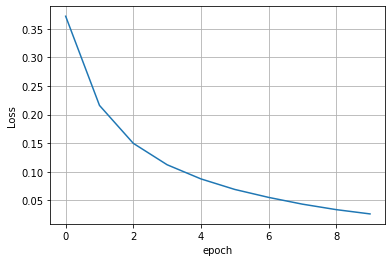

In [ ]:
k = np.arange(10)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.grid()   
plt.plot(k, hist) 
plt.show()

In [ ]:
def predict(model, data_loader):
    output = []
    model.eval()
    with torch.no_grad():
        for x_batch, labels_batch in data_loader:
            preds = model(x_batch)
            pred_labels = torch.argmax(preds, axis=1)
            output.append(pred_labels.cpu().numpy())
    return np.hstack(output)

In [ ]:
pred_labels_train = predict(model, train_loader)
pred_labels_test = predict(model, test_loader)
print("Значение метрики на тренировочной выборке ", accuracy_score(train_sst2_labels.values, pred_labels_train))
print("Значение метрики на тестовой выборке ", accuracy_score(test_sst2_labels.values, pred_labels_test))

Значение метрики на тренировочной выборке  0.9676661849710982
Значение метрики на тестовой выборке  0.8504335260115607


Problem: overfitting!

## Fine-tuning of BERT for sequence classification

In [22]:
train_sst2_data, val_sst2_data, train_sst2_labels, val_sst2_labels = train_test_split(train_sst2_data, train_sst2_labels, train_size=0.9)

In [23]:
tokenized_train = train_sst2_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_val = val_sst2_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [24]:
# padding
padded_train_data = add_padding(tokenized_train)
print(padded_train_data.shape)
# attention mask
mask_train = (padded_train_data > 0).astype(int)
print(mask_train.shape)

(4982, 67)
(4982, 67)


In [25]:
# padding
padded_val_data = add_padding(tokenized_val)
print(padded_val_data.shape)
# attention mask
mask_val = (padded_val_data > 0).astype(int)
print(mask_val.shape)

(554, 55)
(554, 55)


In [34]:
model = ppb.BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
print("Total of model parameters", len(list(model.parameters())))

Total of model parameters 201


In [35]:
train_losses = []
val_losses = []
N_train = padded_train_data.shape[0]
N_val = padded_val_data.shape[0]
batch_size = 32
optimizer = ppb.AdamW(model.parameters(), lr=2e-5)


for epoch in range(3):
    model.train()
    loss_epoch = 0
    metric_epoch = 0
    for i in range(0, N_train, batch_size):
        model.zero_grad() 
        x_batch = torch.tensor(padded_train_data[i:i+batch_size]).to(device)
        mask_batch = torch.tensor(mask_train[i:i+batch_size]).to(device)
        labels_batch = torch.tensor(train_sst2_labels.values[i:i+batch_size]).to(device) 
        loss = model(x_batch, attention_mask=mask_batch, labels=labels_batch).loss
        logits = model(x_batch, attention_mask=mask_batch, labels=labels_batch).logits

        loss_epoch += loss.item()

        pred_labels = torch.argmax(logits, dim=1)
        pred_labels = pred_labels.detach().cpu().numpy()
        true_labels = train_sst2_labels.values[i:i+batch_size]
        metric_epoch += accuracy_score(pred_labels, true_labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    n_batches = N_train // batch_size
    print("Average train loss ", epoch, "epoch: ", loss_epoch / n_batches)
    print("Average train accuracy ", epoch, "epoch", metric_epoch / n_batches)          

    model.eval()
    loss_epoch = 0
    metric_epoch = 0
    for i in range(0, N_val, batch_size):
        x_batch = torch.tensor(padded_val_data[i:i+batch_size]).to(device)
        mask_batch = torch.tensor(mask_val[i:i+batch_size]).to(device)
        labels_batch = torch.tensor(val_sst2_labels.values[i:i+batch_size]).to(device) 
        with torch.no_grad():
            loss = model(x_batch, attention_mask=mask_batch, labels=labels_batch).loss
            logits = model(x_batch, attention_mask=mask_batch, labels=labels_batch).logits
            loss_epoch += loss.item()

            pred_labels = torch.argmax(logits, dim=1)
            pred_labels = pred_labels.detach().cpu().numpy()
            true_labels = val_sst2_labels.values[i:i+batch_size]
            metric_epoch += accuracy_score(pred_labels, true_labels)

    n_batches = N_val // batch_size
    print("Average val loss ", epoch, "epoch: ", loss_epoch / n_batches)
    print("Average  val accuracy ", epoch, "epoch", metric_epoch / n_batches) 

Average train loss  0 epoch:  0.4214730108457227
Average train accuracy  0 epoch 0.8251466275659823
Average val loss  0 epoch:  0.2603289590162389
Average  val accuracy  0 epoch 0.9577205882352942
Average train loss  1 epoch:  0.18505291589685985
Average train accuracy  1 epoch 0.9420637829912024
Average val loss  1 epoch:  0.2904391853577074
Average  val accuracy  1 epoch 0.9724264705882353
Average train loss  2 epoch:  0.10278302272030664
Average train accuracy  2 epoch 0.9780241935483871
Average val loss  2 epoch:  0.3330687187228571
Average  val accuracy  2 epoch 0.9669117647058824


Fine-tuning helped both correct parameters and avoid overfitting: average validation accuracy is even higher than train accuracy

In [36]:
model.eval()
N_test = len(padded_test_data)
n_batch = N_test // batch_size 
total_metric = 0

for i in range(0, N_test, batch_size):
      x_batch = torch.tensor(padded_test_data[i:i+batch_size]).to(device)
      mask_batch = torch.tensor(mask_test[i:i+batch_size]).to(device)
      labels_batch = torch.tensor(test_sst2_labels.values[i:i+batch_size]).to(device) 
      with torch.no_grad():
          logits = model(x_batch, attention_mask=mask_batch).logits
          pred_labels = torch.argmax(logits, dim=1)
          pred_labels = pred_labels.detach().cpu().numpy()
          true_labels = test_sst2_labels.values[i:i+batch_size]
          total_metric += accuracy_score(pred_labels, true_labels)
print("Average metric value on the test set:", total_metric / n_batch)

Average metric value on the test set: 0.9280523255813954


Metric on test significantly improved!